In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../Datasets/preprocessed_liver_data.csv')
df.columns = df.columns.str.strip()
print("Cleaned column names:", list(df.columns))
df.head()

Cleaned column names: ['Age of the patient', 'Total Bilirubin', 'Direct Bilirubin', 'Alkphos Alkaline Phosphotase', 'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase', 'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio', 'Result', 'Gender']


,Age of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result,Gender
0,1.287819,-0.422356,-0.488751,-0.421797,-0.354642,-0.330845,0.281269,0.203581,-0.143007,1,-1.577290
1,1.105494,1.267620,1.417009,1.748866,-0.086643,-0.034009,0.929662,0.076208,-0.645554,1,0.633999
2,1.105494,0.671158,0.922923,0.862794,-0.108976,-0.149847,0.466524,0.203581,-0.174416,1,0.633999
3,0.862394,-0.372651,-0.382875,-0.442995,-0.365808,-0.323605,0.281269,0.330954,0.171085,1,0.633999
4,1.713244,0.107832,0.181795,-0.387880,-0.293225,-0.182427,0.744407,-0.942775,-1.713467,1,0.633999


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop('Result', axis=1) 
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
# Check class distribution
print("Training set distribution:")
print(y_train.value_counts())
print((y_train.value_counts() / len(y_train)) * 100)

print("\nTest set distribution:")
print(y_test.value_counts())
print((y_test.value_counts() / len(y_test)) * 100)


Training set distribution:
Result
1    11049
0     4445
Name: count, dtype: int64
Result
1    71.311475
0    28.688525
Name: count, dtype: float64

Test set distribution:
Result
1    2762
0    1112
Name: count, dtype: int64
Result
1    71.295818
0    28.704182
Name: count, dtype: float64


# Class Balancing and SMOTE

In [4]:
from imblearn.over_sampling import SMOTE

# Check class distribution before balancing
print("Before SMOTE:", y_train.value_counts())

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_bal.value_counts())

Before SMOTE: Result
1    11049
0     4445
Name: count, dtype: int64
After SMOTE: Result
1    11049
0    11049
Name: count, dtype: int64


# Training Random Forest Classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_bal, y_train_bal)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.9971605575632422
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1112
           1       1.00      1.00      1.00      2762

    accuracy                           1.00      3874
   macro avg       1.00      1.00      1.00      3874
weighted avg       1.00      1.00      1.00      3874


Confusion Matrix (Random Forest):
 [[1108    4]
 [   7 2755]]


<Axes: >

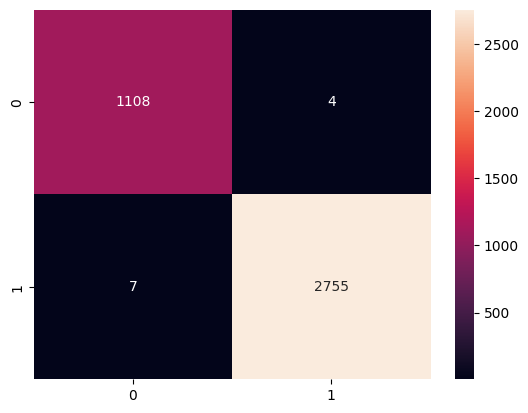

In [6]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf),annot=True,fmt="d")

# Training XGBoost Classifier

In [7]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, scale_pos_weight=1, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9971605575632422

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1112
           1       1.00      1.00      1.00      2762

    accuracy                           1.00      3874
   macro avg       1.00      1.00      1.00      3874
weighted avg       1.00      1.00      1.00      3874


Confusion Matrix (XGBoost):
 [[1106    6]
 [   5 2757]]


<Axes: >

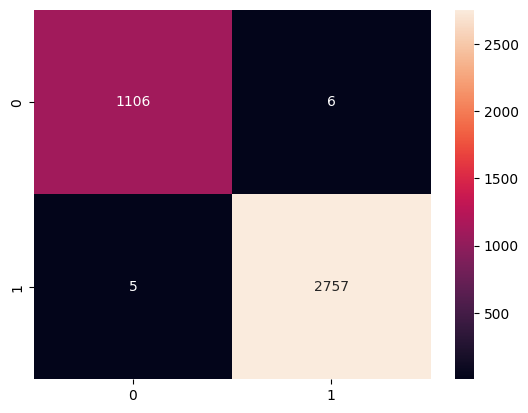

In [8]:
sns.heatmap(confusion_matrix(y_test,y_pred_xgb),annot=True,fmt="d")

# Tuning Hyperparameters

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, scale_pos_weight=1, eval_metric='logloss')
grid = GridSearchCV(xgb, params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_bal, y_train_bal)

best_xgb = grid.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print("Best XGBoost Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print(grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost Accuracy: 0.996386164171399
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [10]:
results_df = pd.DataFrame({
    'Model': ['Random Forest','XGBoost', 'XGBoost (Tuned)'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf),accuracy_score(y_test, y_pred_xgb),accuracy_score(y_test, y_pred_best_xgb)]
})
print(results_df)

             Model  Accuracy
0    Random Forest  0.997161
1          XGBoost  0.997161
2  XGBoost (Tuned)  0.996386


# Final Model - Random Forest Classifier

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# Re-create and re-train pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        class_weight="balanced",
        n_estimators=200,
        random_state=42))
])

pipe.fit(X_train_bal, y_train_bal)

# Save pipeline
joblib.dump(pipe, "rf_pipeline.pkl")
print("Pipeline saved as rf_pipeline.pkl")

Pipeline saved as rf_pipeline.pkl
